In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# from scapy.all import *
# from pcapng import FileScanner
import networkx as nx
from mpl_toolkits.mplot3d import axes3d
import os 

import torch
import torch.optim as optim
import torch.nn as nn

import seaborn as sns
from torch.nn import Sequential
import random
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn.functional as F
from torch.utils.data import Dataset ,DataLoader
from torchvision import transforms


from torch_geometric.nn import GCNConv
from pycaret.regression import *
from sklearn.model_selection import train_test_split
from pycaret.datasets import get_data
from sklearn.preprocessing import OneHotEncoder
from torch_geometric.utils import to_networkx

from torch_geometric.utils import to_networkx

import sklearn
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn import metrics
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    print(f"set_seed_{seed}")
set_seed(42)

from tqdm.auto import trange,tqdm
from torch_geometric.datasets import Planetoid
from modules.metrics import *
%matplotlib inline
print("PyTorch has version {}".format(torch.__version__))

# from torch_geometric.datasets import CoraFull

set_seed_42
PyTorch has version 1.13.0


In [2]:
import numpy as np
import scipy.sparse as sp
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot
def load_data(path="../data/cora/", dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [3]:
adj, features, labels, idx_train, idx_val, idx_test = load_data(path="./Cora/",dataset="Cora")

Loading Cora dataset...


## csv에서 Graph를 만드는 방법 

In [4]:
edgelist = pd.read_csv("./Cora/cora.cites", sep='\t', header=None, names=["target", "source"])
# edgelist["label"] = "cites"
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
content  = pd.read_csv("./Cora/cora.content",sep='\t',header=None,names =column_names)
label_list = list(pd.get_dummies(content['subject']).columns)
Ordinary_encode = {i:idx for idx,i in enumerate(label_list)}
content["subject"] = content["subject"].map(Ordinary_encode)


In [5]:
import torch
from torch_geometric.data import Data

content_encoded , _ = content["subject"].factorize()

content = content.sort_index()

df_x = content.drop("subject",axis=1)
df_y = pd.get_dummies(content["subject"])
edge_index = torch.tensor(np.array(edgelist))
edge_reverse_index =torch.concat([edge_index[:,1].reshape(-1,1),edge_index[:,0].reshape(-1,1)],dim=1)
undirected_edge_index = torch.concat([edge_index,edge_reverse_index])
x = torch.tensor(np.array(df_x.sort_index()),dtype=torch.float32)
y = torch.tensor(np.array(content_encoded),dtype = torch.float32)

In [6]:
# edge_order =  {i:idx for idx,i in enumerate(pd.concat([edgelist["source"],edgelist['target']],axis=0).sort_values().unique())}
# edgelist['target'] = edgelist['target'].map(edge_order)
# edgelist['source'] = edgelist['source'].map(edge_order)


---------------------
# PyG에 존재하는 Dataset을 import 

In [7]:
if "IS_GRADESCOPE_ENV" not in os.environ:
    root = './Cora'
    name = "Cora"
    cora = Planetoid(root,name)
data = cora.data

# Dataset feature

In [8]:
print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(2*data.num_edges) / data.num_nodes:.2f}')#방향 그래프라서 edge*2? 
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 7.80
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


# Show the Graph used by Networkx

In [9]:
from torch_geometric.utils import to_networkx

G = to_networkx(data,to_undirected=True)

In [10]:
subG = to_networkx(data.subgraph(torch.arange(500)))

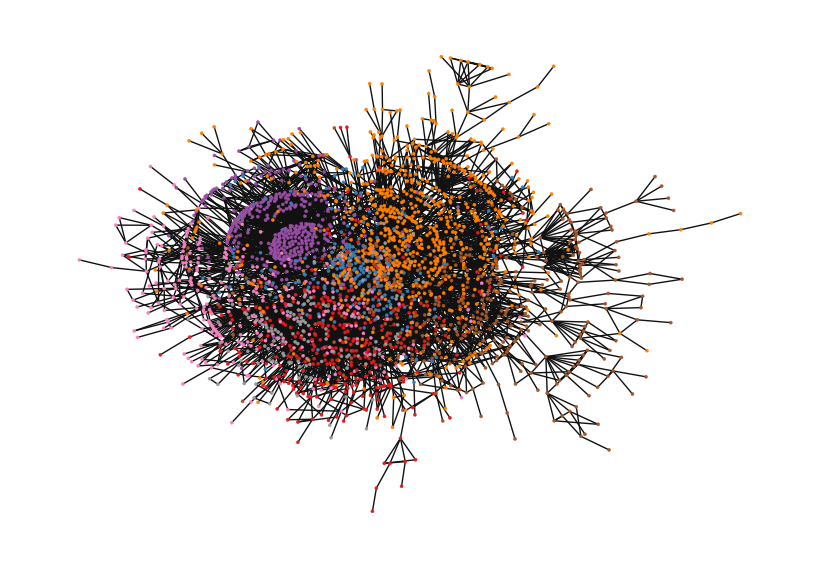

In [37]:
# nx.draw(G,pos=nx.spring_layout(G))
# nx.draw(G,pos = nx.kamada_kawai_layout(G),node_size = 5, node_color='#00b4d9')
nx.draw(G,pos = nx.kamada_kawai_layout(G),node_size = 5,node_color=data.y,cmap="Set1")

plt.savefig("./jpeg/graph.jpeg",dpi=200)

In [11]:
def plot_subgraph(dataset,color, sub_graph_num =500,to_undirected=True):
    sub_G = to_networkx(dataset.subgraph(torch.arange(sub_graph_num)),to_undirected=to_undirected)
    nx.draw(sub_G,pos = nx.kamada_kawai_layout(sub_G),node_size = 8,  node_color=data.y[:sub_graph_num],cmap="Set1")# node_color='#00b4d9'
    plt.savefig(f"./jpeg/{sub_graph_num}_graph.jpeg",dpi=200)

## subgraph를 보고 싶을 때

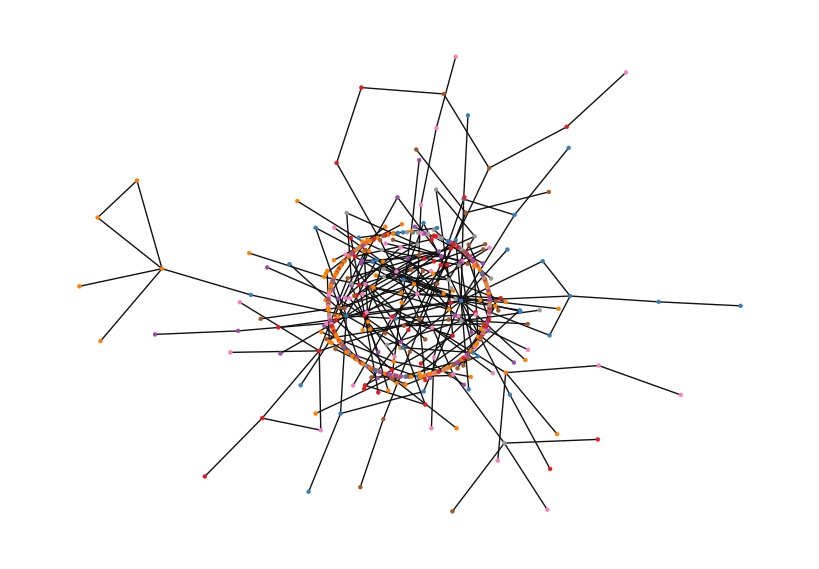

In [12]:
plot_subgraph(data,sub_graph_num=500,color=data.y)

In [13]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [14]:
data.x.shape

torch.Size([2708, 1433])

In [28]:
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=20, c=color, cmap="Set1")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16,color ='black')
            plt.tight_layout()
            plt.savefig(f'./jpeg/{epoch}th_2.jpeg',dpi = 200)
            
    else:
        nx.draw_networkx(G, pos = nx.kamada_kawai_layout(G, seed=42), with_labels=True,
                         node_color=color, cmap="Set1")
    plt.show()

# GCN정의 

Embedding shape: [1326, 2]


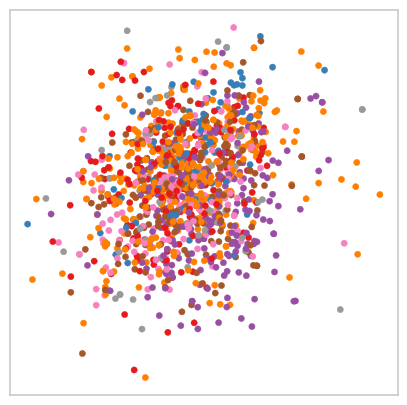

In [43]:
from torch_geometric.nn import GCNConv,GATConv ,BatchNorm
class GCN(torch.nn.Module):
    def __init__(self,feature_shape, num_classes):
        super(GCN,self).__init__()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.gcn1 = GCNConv(feature_shape,14) #GNN은 Layer가 얕을 수록 학습 효과가 좋음, 3,4layer 이후는 Residual block필수
        self.bn   = nn.BatchNorm1d(14)
        self.gcn2 = GCNConv(14,num_classes)
        
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(num_classes,2) #
    def forward(self,x,edge_index):
        x = self.tanh(self.bn(self.gcn1(x,edge_index)))
        x = self.dropout(x)
        out = self.tanh(self.gcn2(x,edge_index))
        embeddings = self.fc(out) #why? maybe mapping the real euclidean space
         
        return out, embeddings
        
model = GCN(data.x.shape[-1],cora.num_classes)
_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

In [ ]:
# if "IS_GRADESCOPE_ENV" not in os.environ:
#     root = './Cora'
#     name = "Cora"
#     cora = Planetoid(root,name)
# data = cora.data

In [48]:
#subgraph를 활용하여 , train,test로 분리
train_data = data.subgraph(torch.arange(int(len(data.x)*0.7)))
test_data = data.subgraph(torch.arange(int(len(data.x)*0.7),len(data.x)))

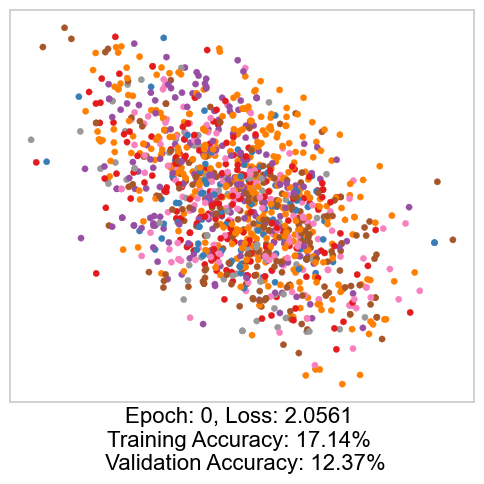

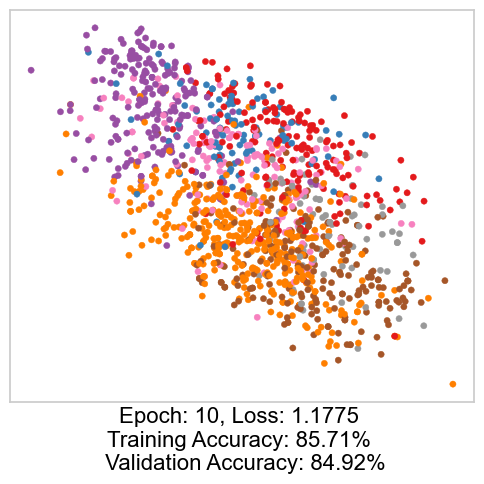

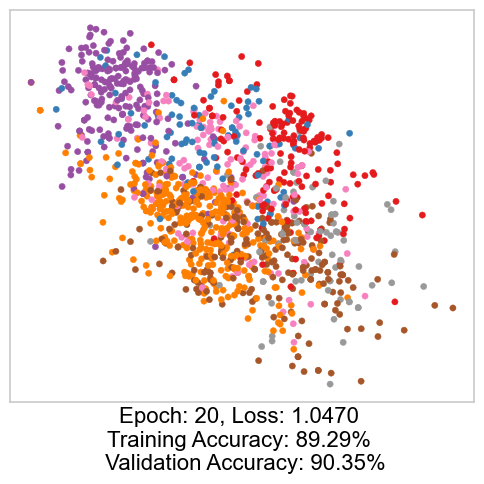

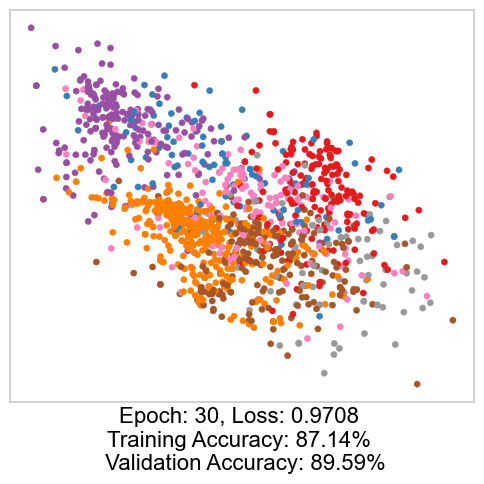

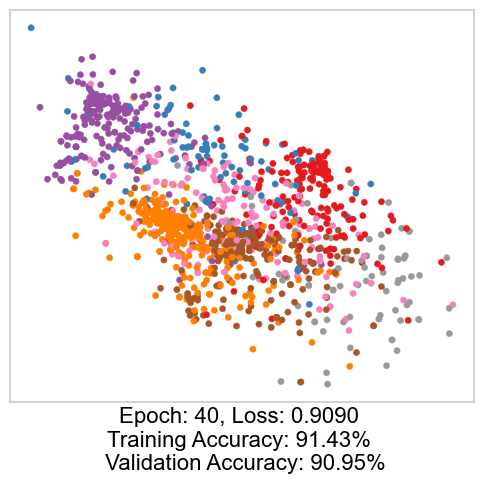

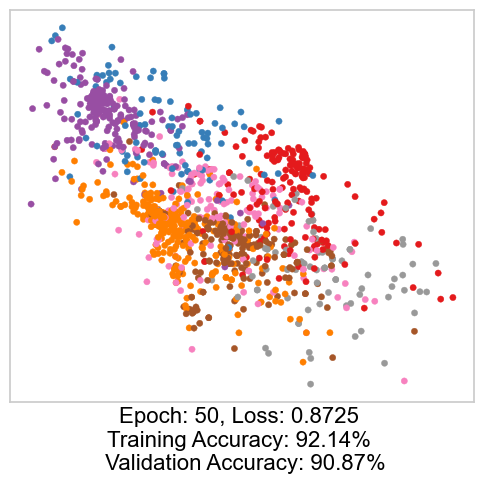

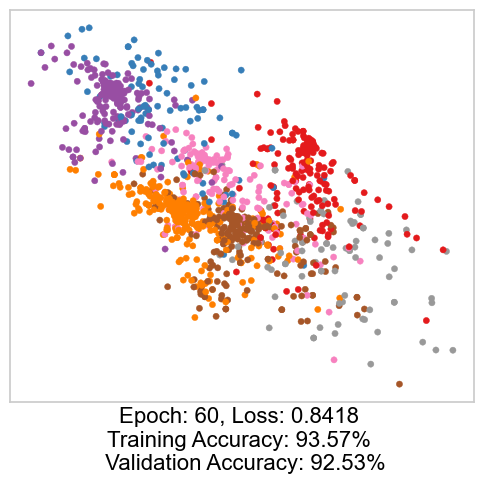

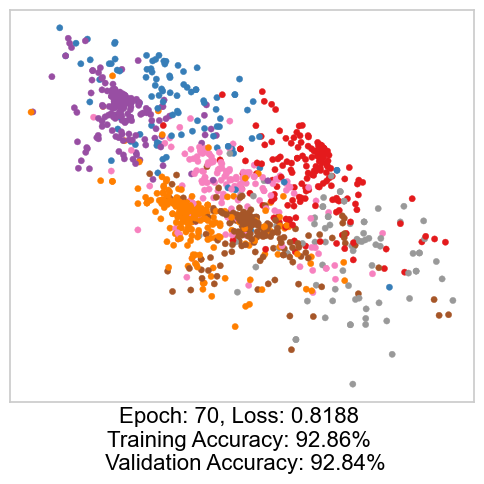

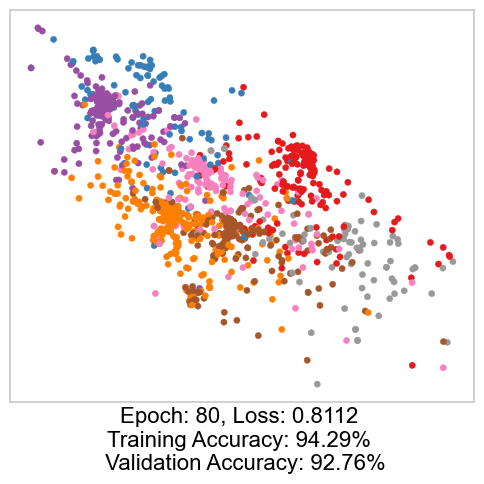

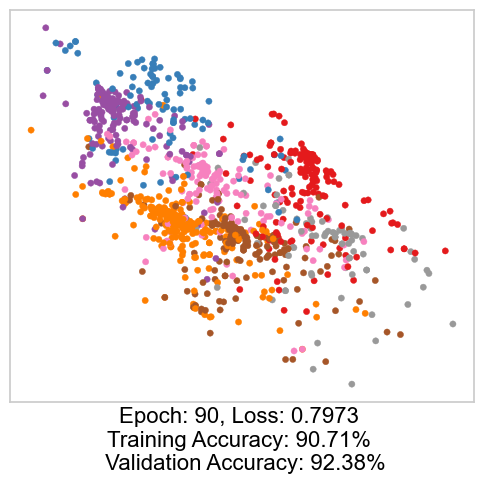

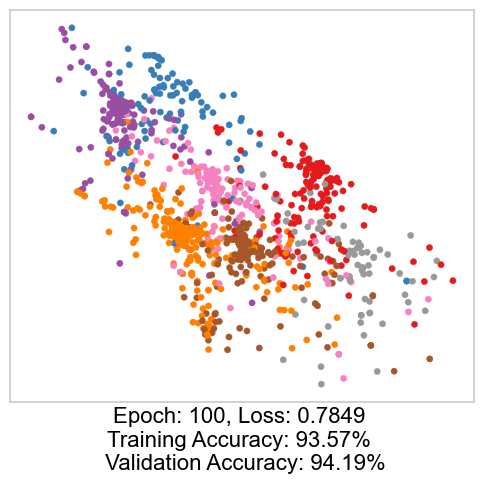

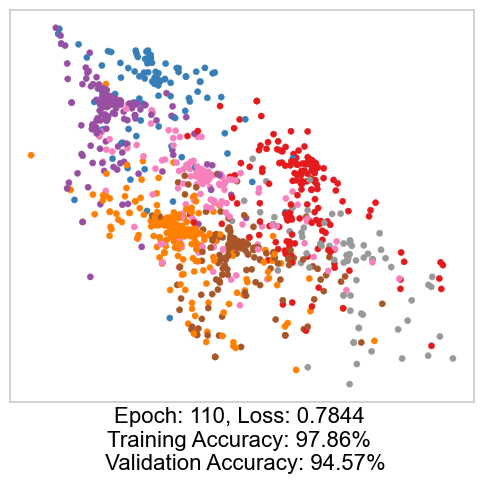

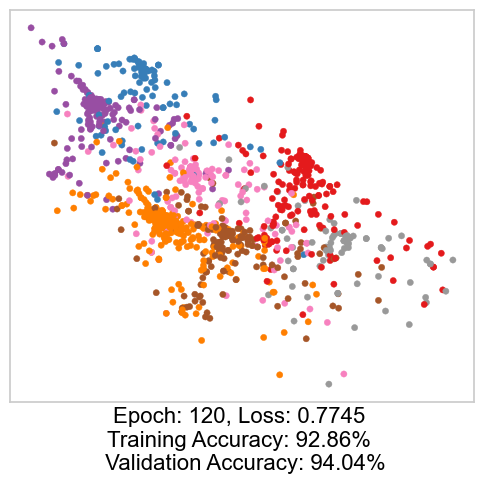

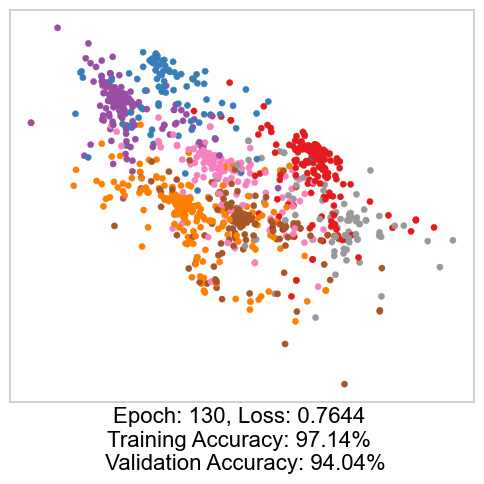

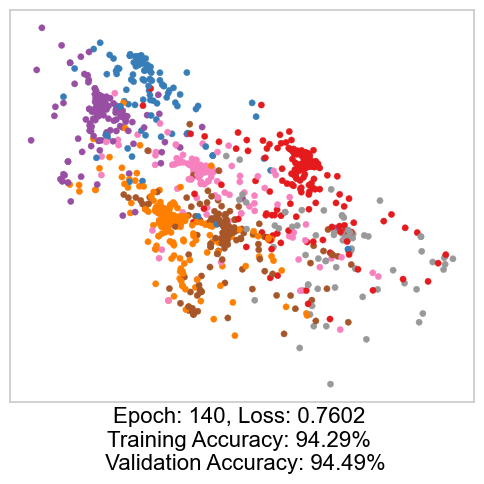

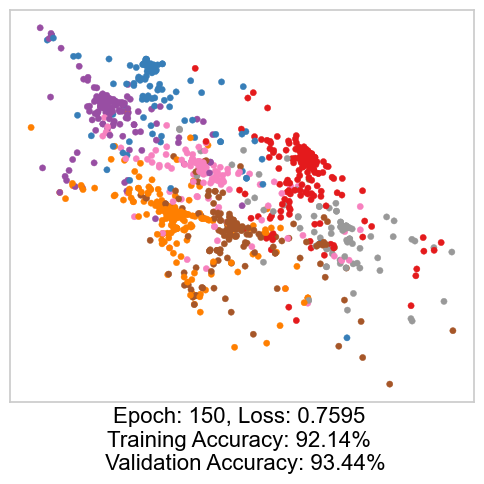

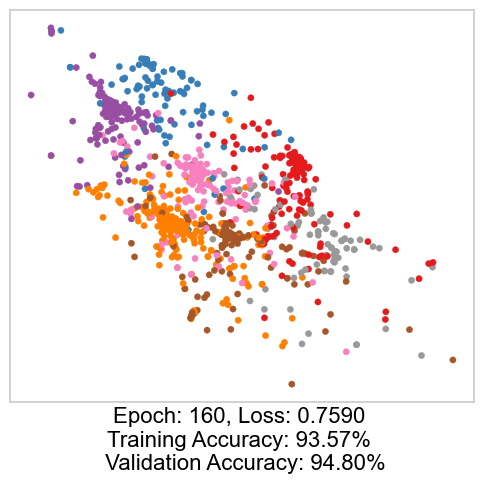

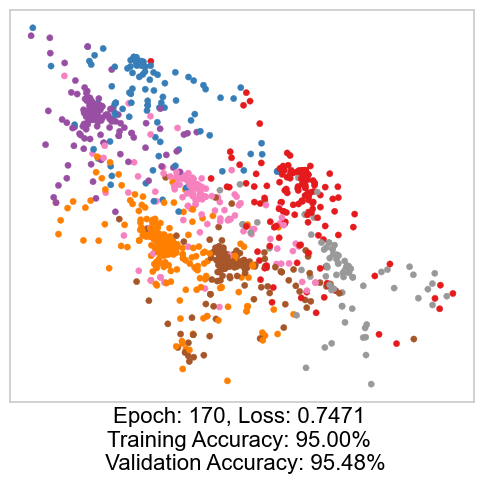

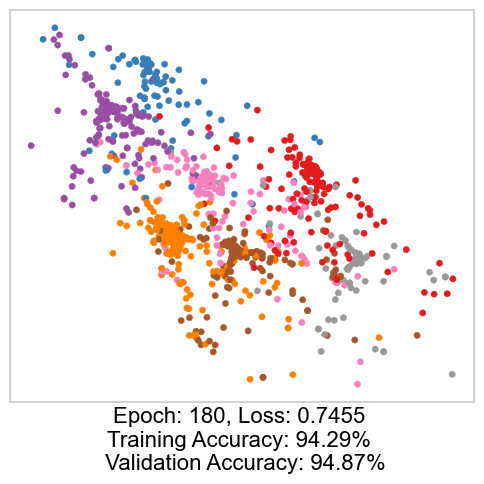

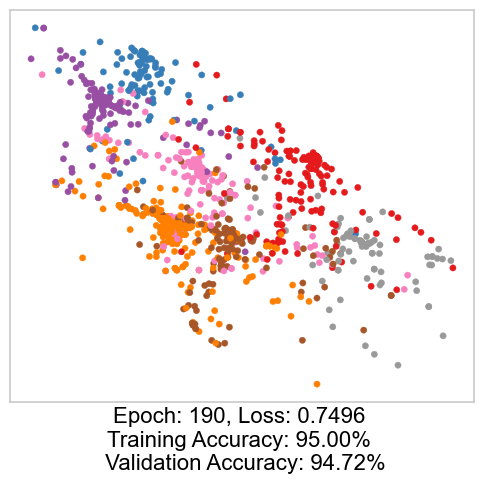

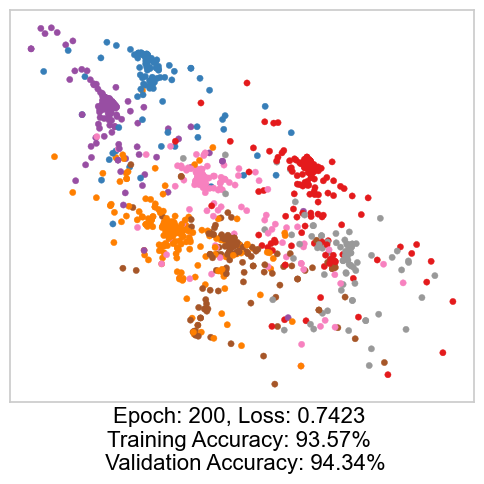

In [44]:
import time
model = GCN(data.x.shape[-1],cora.num_classes)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.
# semisuptervised가 아닌 super vised learning을 진행할 것임
def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
    
    # loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    # semi supervised learning을 할때는 train_mask를 사용하지만, super vised Learning은 사용하지 않음
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    # predicted_classes = torch.argmax(out, axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    
    target_classes = data.y[data.train_mask]
    # target_classes = data.y
    
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())
    
    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

for epoch in range(201):
    data = train_data
    loss, h, accuracy = train(data)
    # Visualize the node embeddings every 10 epochs
    if  epoch%10==0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)
        time.sleep(0.1)

# Test dataset으로 결과 확인

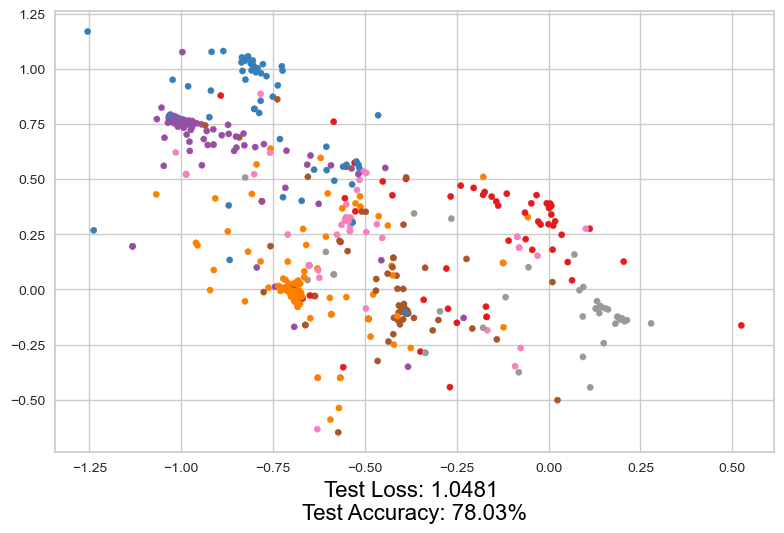

In [45]:
# loss, h, accuracy = train(test_data)
# Visualize the node embeddings every 10 epochs

with torch.no_grad():
    model.eval()
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(test_data.x, test_data.edge_index)  # Perform a single forward pass.
    loss = criterion(out, test_data.y)  # Compute the loss solely based on the training nodes.
    predicted_classes = torch.argmax(out, axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = test_data.y
    test_accuracy = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())
color=test_data.y
h = h.detach().cpu().numpy()
plt.scatter(h[:, 0], h[:, 1], s=20, c=color, cmap="Set1")
plt.xlabel((f"Test Loss: {loss.item():.4f} \nTest Accuracy: {test_accuracy*100:.2f}%"),fontsize=16,color ='black')
plt.tight_layout()
plt.savefig(f'./jpeg/test_result.jpeg',dpi = 200)

# Final Project.jupyter에서 가지고 온 Data Frame

In [296]:
model_name.append("GCN")

acc.append(0.7803)
result_df = pd.DataFrame({'Model': model_name, 'Score': np.array(acc)}).reset_index(drop=True)
result_df

,Model,Score
0,LogisticRegression,0.720000
1,SGDClassifier,0.683077
2,GradientBoostingClassifier,0.712308
3,DecisionTreeClassifier,0.590769
4,RandomForestClassifier,0.664615
5,ensemble_model,0.743542
6,DNN,0.745387
7,GCN,0.780300


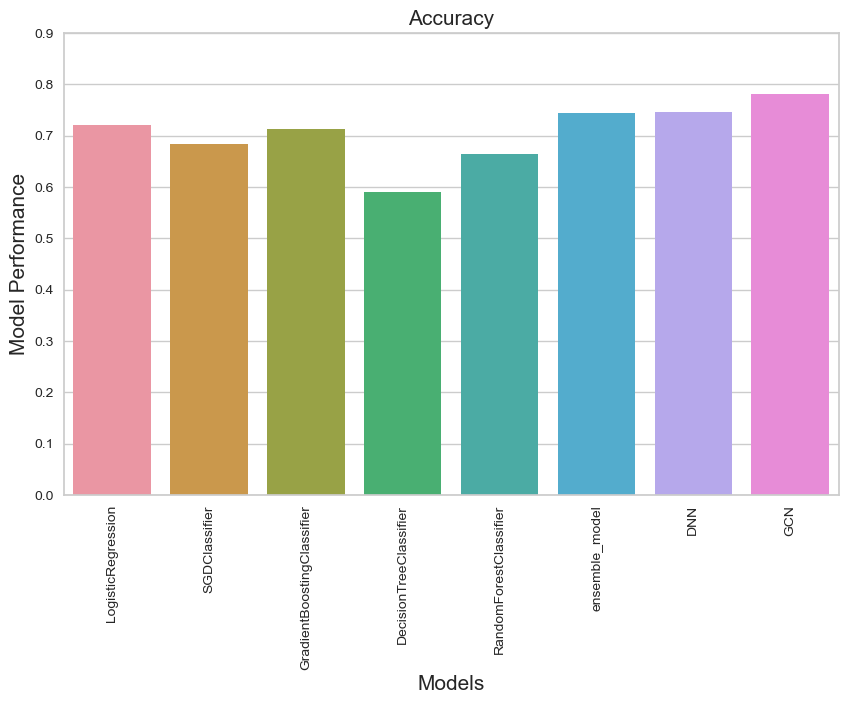

In [297]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'],)
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0, 0.9)
plt.title('Accuracy', fontsize=15)
plt.show()